## Import

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql import Window as Window
import plotly.express as px
import utils

## Config

In [2]:
SPARK_THREADS = 6
SPARK_MEMORY = 6
SPARK_TIMEZONE = 'Asia/Tehran'
ADJUST_SAMPLED_DATA = 'adjust_sampled_data.csv'

### Instantization

In [3]:
spark = (
    SparkSession 
    .builder 
    .master('local[{}]'.format(SPARK_THREADS)) 
    .config('spark.driver.memory', '{}g'.format(SPARK_MEMORY)) 
    .config('spark.sql.session.timeZone', SPARK_TIMEZONE) 
    .getOrCreate()
)

## Data Access

In [4]:
adjust_sampled_df = spark.read.csv(ADJUST_SAMPLED_DATA, header = True)

In [5]:
adjust_sampled_df.describe().show()

+-------+-----------------+--------------------+--------------------+-------------------+-------------+---------------+-------------------+
|summary|              _c0|                adid|        network_name|       installed_at|activity_kind|     event_name|         created_at|
+-------+-----------------+--------------------+--------------------+-------------------+-------------+---------------+-------------------+
|  count|           785168|              785168|              785168|             785168|       785168|         681147|             785168|
|   mean|         392583.5|                null|                null|               null|         null|           null|               null|
| stddev|226658.6224170614|                null|                null|               null|         null|           null|               null|
|    min|                0|0000de7e4253d365b...|Adwords UAC Installs|2019-07-06 00:00:00|        event|    get_contact|2019-07-06 00:00:00|
|    max|           

## EDA

### Reconize problems in data

In [6]:
adjust_sampled_df.filter(F.col('event_name').isNull()).filter(F.col('activity_kind')== "event").count()

0

### Filter If action time is less than install

In [7]:
adjusted_sampled_clean_df = (
    adjust_sampled_df
    .withColumn('installed_at' , F.to_timestamp(F.col('installed_at')))
    .withColumn('created_at' , F.to_timestamp(F.col('created_at')))
    .filter(F.col('created_at') >= F.col('installed_at'))
)
adjusted_sampled_clean_df.show()

+---+--------------------+------------+-------------------+-------------+---------------+-------------------+
|_c0|                adid|network_name|       installed_at|activity_kind|     event_name|         created_at|
+---+--------------------+------------+-------------------+-------------+---------------+-------------------+
|  0|1dcedd19b197650bd...|     Organic|2019-07-06 00:07:04|        event|    get_contact|2019-07-08 15:33:44|
|  1|d621e1bfa590881a6...|     Organic|2019-07-06 00:14:50|        event|    get_contact|2019-07-08 15:53:04|
|  2|7107c045edc8eb474...|     Organic|2019-07-06 00:33:40|        event|new_post_submit|2019-07-08 10:24:14|
|  3|32a53ff379ace92a6...|     Organic|2019-07-06 02:33:10|        event|    get_contact|2019-07-08 09:21:11|
|  4|1eaeca850ef726e6c...|     Organic|2019-07-06 03:28:56|        event|    get_contact|2019-07-06 14:00:28|
|  5|e779db434ffd0fb34...|     Organic|2019-07-06 04:30:05|        event|    get_contact|2019-07-07 22:21:19|
|  6|1f9a6

### Activity Kind Description

In [8]:
activity_kind_count_df = (
    adjusted_sampled_clean_df
        .groupby(F.col('activity_kind')).agg(F.count('*').alias('activity_frequency'))
)
activity_kind_count_df.show()

+-------------+------------------+
|activity_kind|activity_frequency|
+-------------+------------------+
|    uninstall|             14639|
|      install|             89382|
|        event|            681145|
+-------------+------------------+



#### Activity Kind Bar Plot

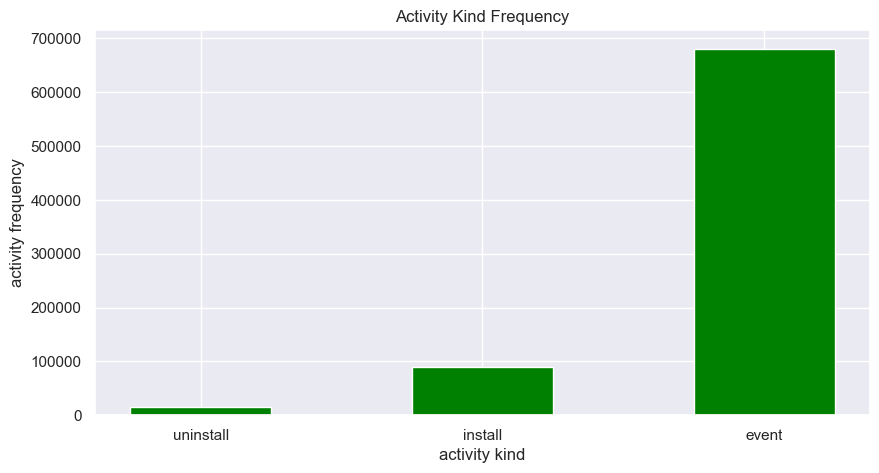

In [9]:
activity_kind_count_pd=activity_kind_count_df.toPandas()
utils.plot_bar_plot(activity_kind_count_pd,
              x_col='activity_kind',
              height_col='activity_frequency',
              x_label='activity kind',
              y_label='activity frequency',
              title='Activity Kind Frequency'
             )

### Histogram Activities

#### Pre Processing Histogram

In [10]:
created_at_frequency_df=(
    adjusted_sampled_clean_df.withColumn('date' , F.date_trunc('day','created_at'))
    .groupby('_c0' , 'network_name' ,'date').count()
    .withColumn("date", F.date_format("date", "yyyy-MM-dd HH:mm:ss"))
    
)
created_at_frequency_pd = created_at_frequency_df.toPandas()

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

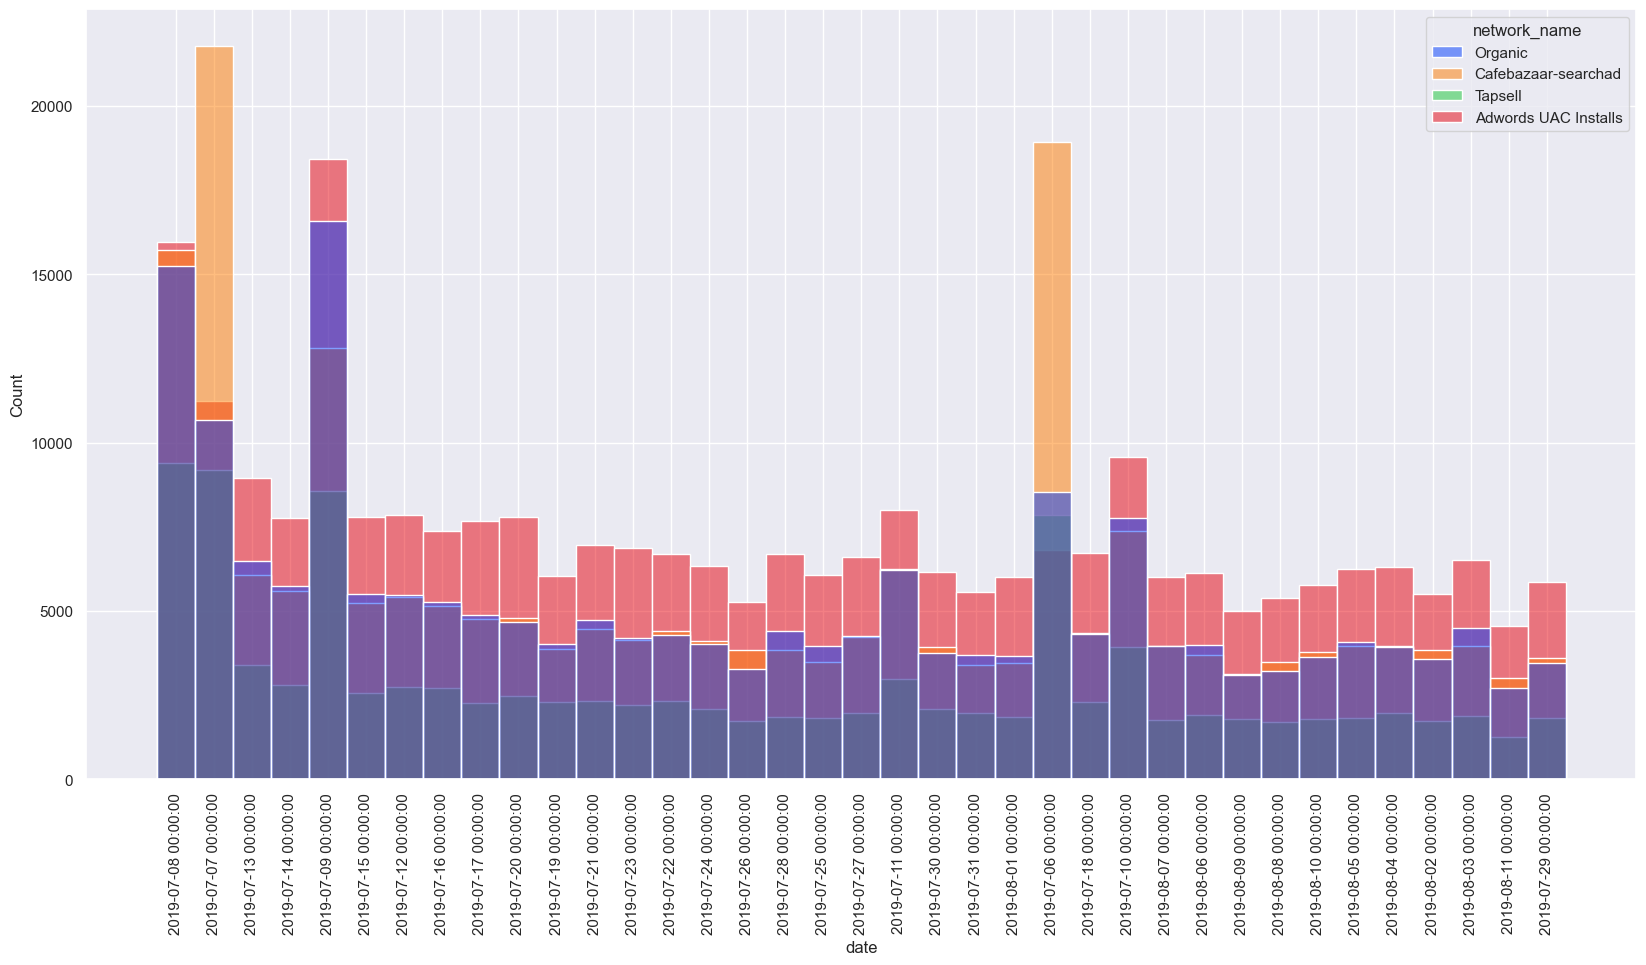

In [11]:
_, ax = plt.subplots(figsize=(20, 10))
sns.histplot(data = created_at_frequency_pd,
    x= 'date',bins=30,
    hue = 'network_name',
    palette='bright',
    ax=ax,
    );
plt.xticks(rotation=90);

### Event Kind Sunburst

In [12]:
event_activity_df=(
    adjusted_sampled_clean_df.groupby('event_name' , 'activity_kind', 'network_name').count()
)
event_activity_pd=event_activity_df.toPandas()
fig = px.sunburst(
    event_activity_pd,
    path=['network_name', 'activity_kind', 'event_name'],
    values='count'
)
fig.show()

### ScatterPLot Function

### Event Per Day Per User ScatterPlot

In [13]:
def scattet_plot_user(network_name):
    event_per_user_per_day_df=(
        adjusted_sampled_clean_df
        .filter(F.col('event_name').isNotNull())
        .filter(F.col('network_name')==network_name)
        .groupby(F.date_format(F.date_trunc('day' , 'created_at') , "yyyy-MM-dd").alias('date'),'event_name')
        .agg(F.count('event_name').alias('event_count'),F.countDistinct('adid').alias('Users'))
    )
    event_per_user_per_day_pd=event_per_user_per_day_df.toPandas()
    _, ax = plt.subplots(figsize=(20, 10))
    plot = sns.scatterplot(data=event_per_user_per_day_pd,
         x='date',
         y='event_count',
        hue='event_name',
        size='Users',
        ax=ax
    );
    plt.setp(plot.get_xticklabels(), rotation=45)

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn

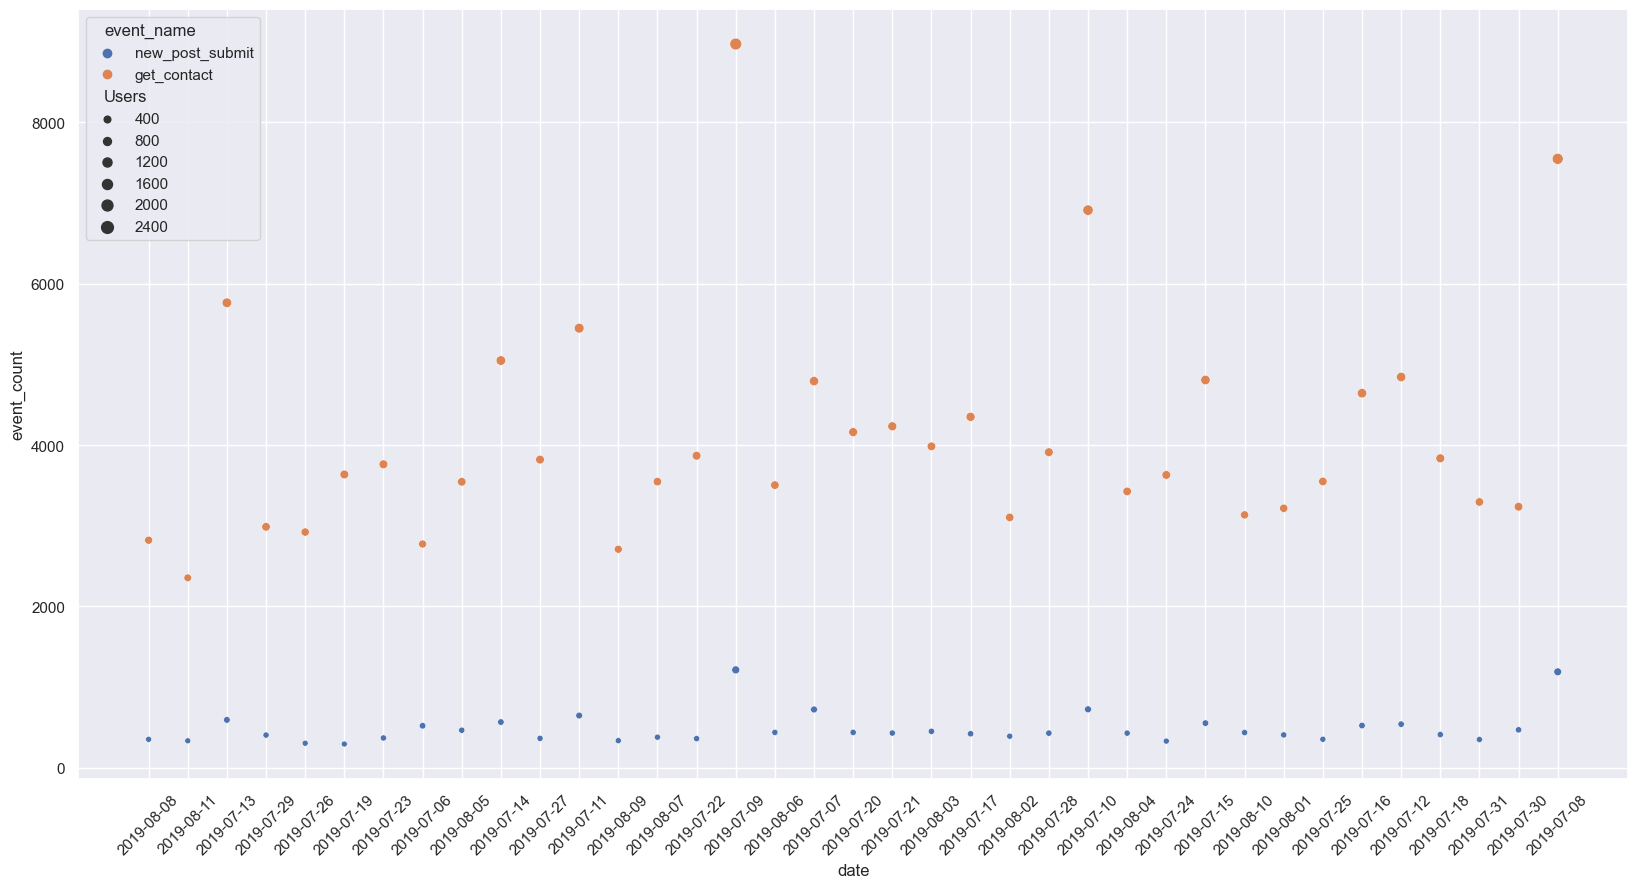

In [14]:
scattet_plot_user(network_name='Organic')

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn

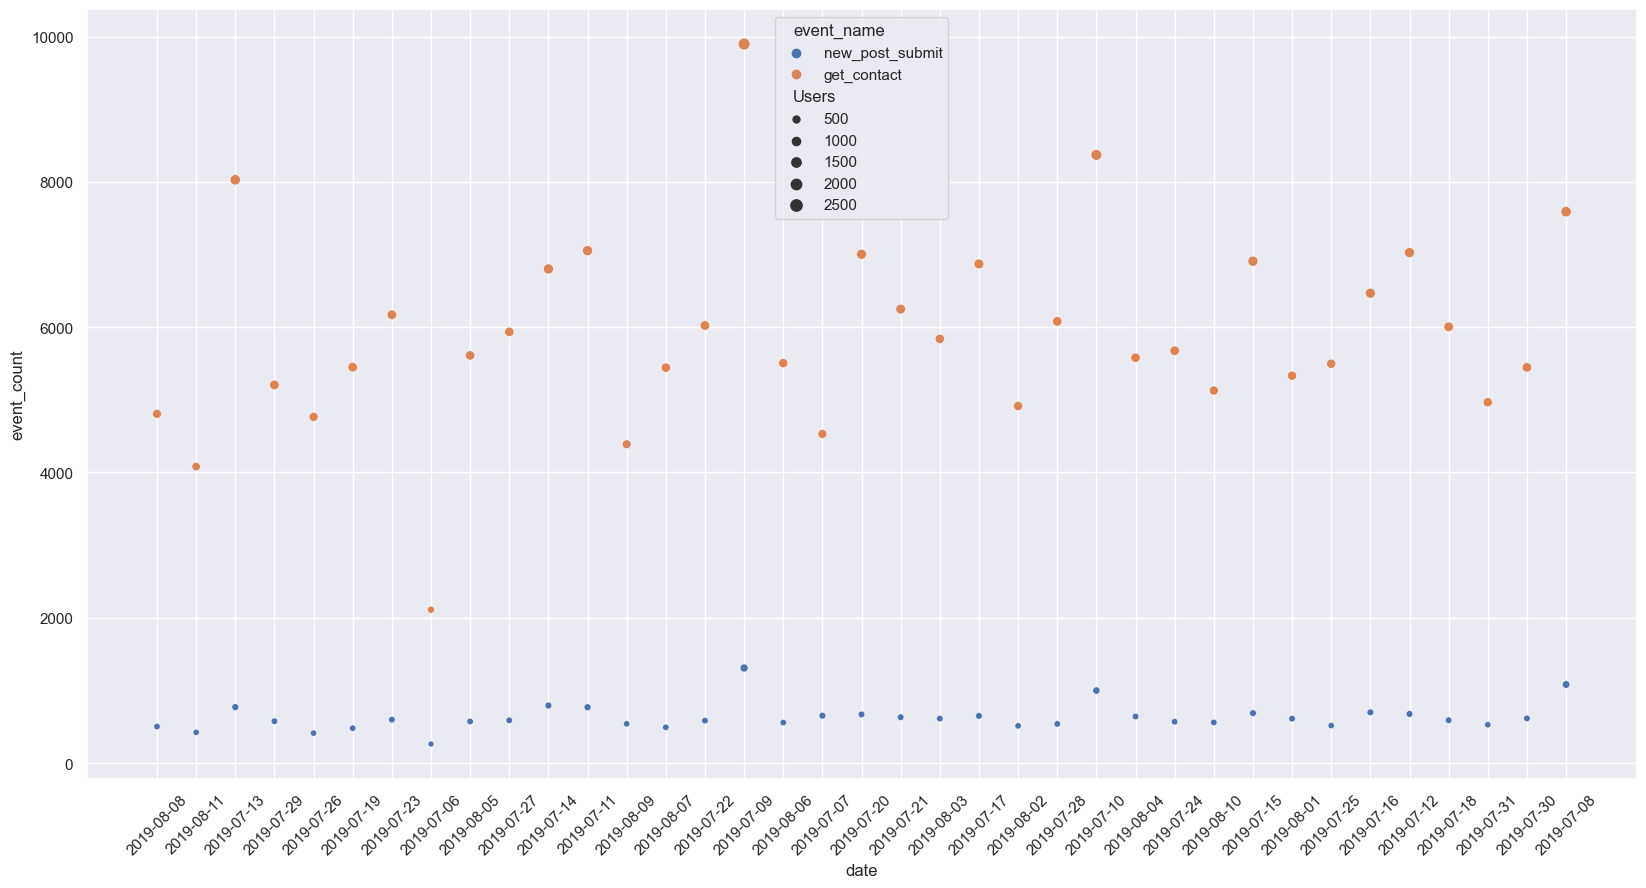

In [15]:
scattet_plot_user(network_name='Adwords UAC Installs')

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn

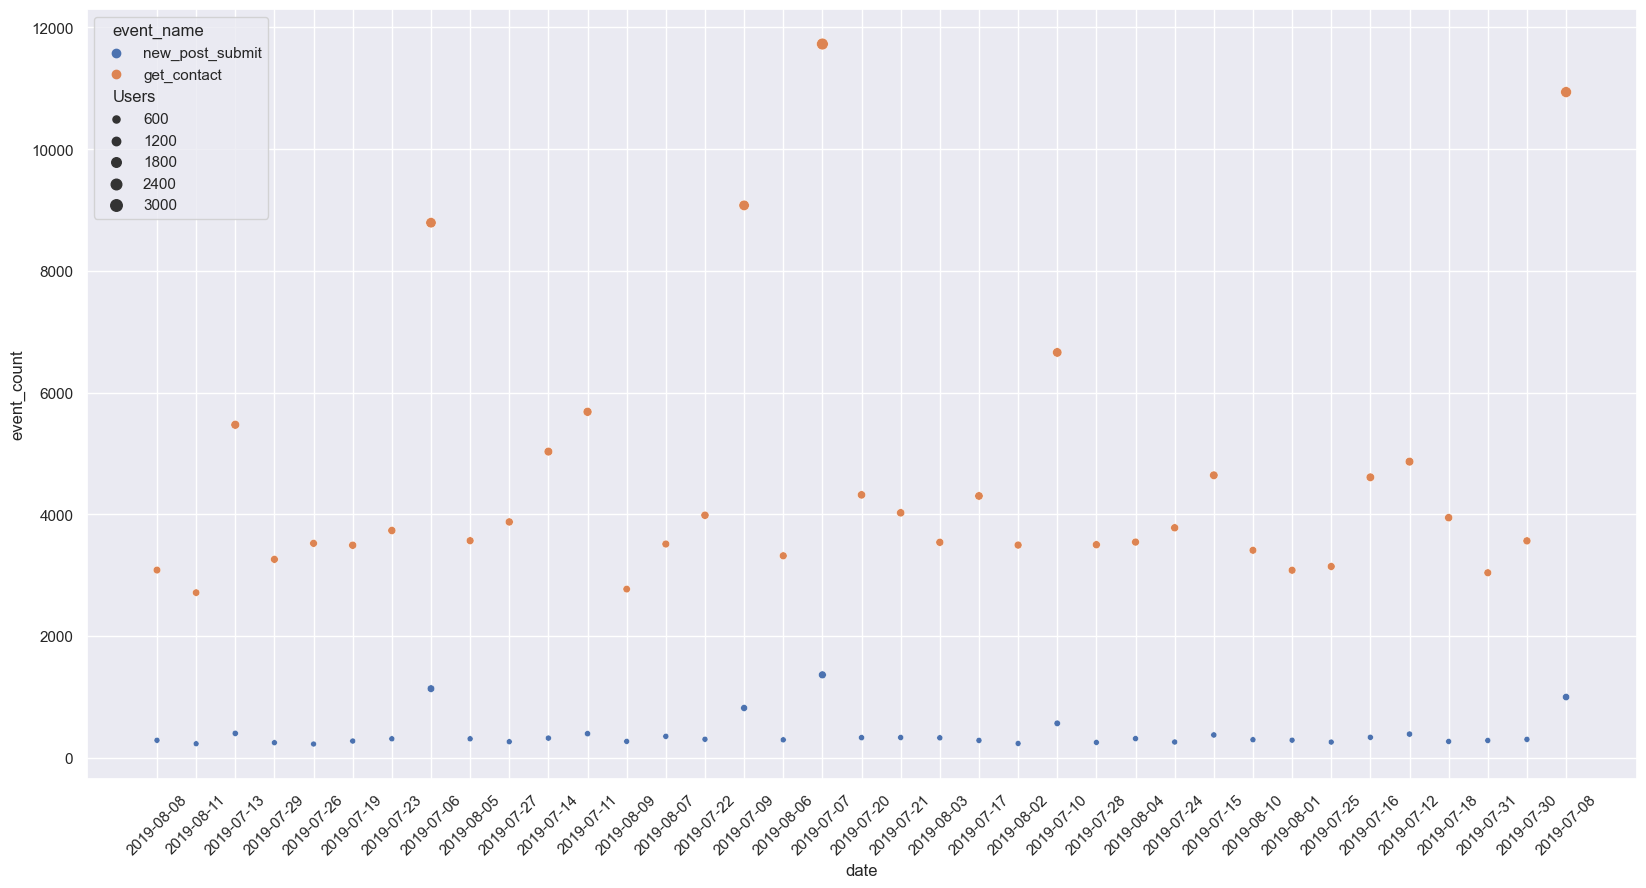

In [16]:
scattet_plot_user(network_name='Cafebazaar-searchad')

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn

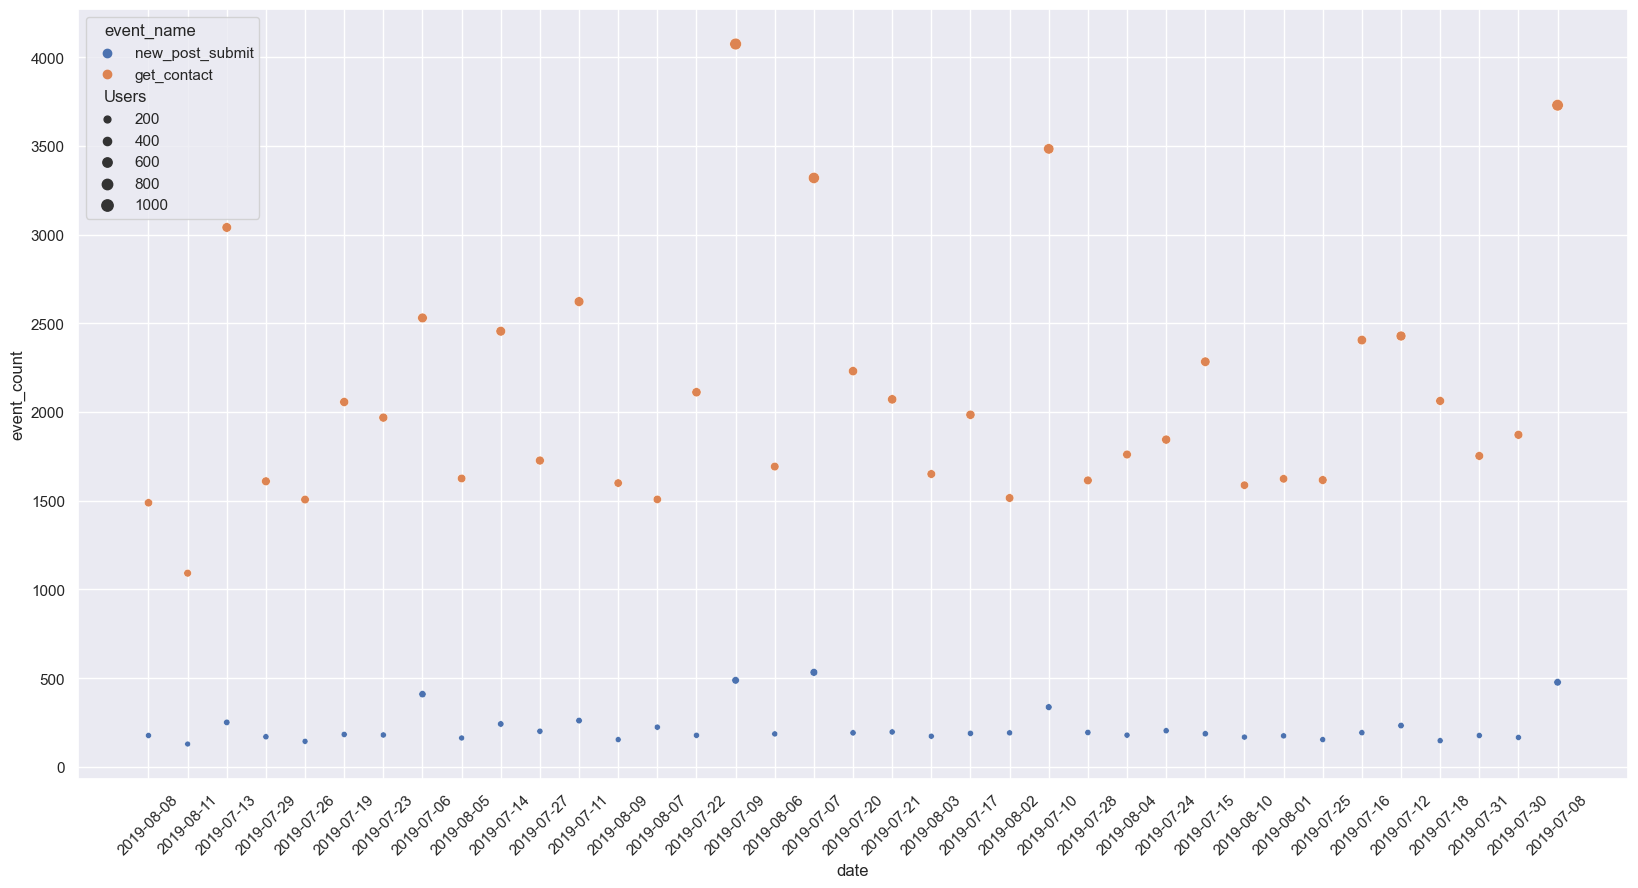

In [17]:
scattet_plot_user(network_name='Tapsell')

## Part 1

### The percentage of users who finally performed an important event within three days after installation

In [18]:
user_return_in_three_day_df=(
    adjusted_sampled_clean_df
    .withColumn("is_returned_in_three_day",
               F.when(F.col('created_at').between(F.col('installed_at'),F.date_add(F.col('installed_at') , 3 ))
                      & (F.col('activity_kind')=='event'), 1).otherwise(0))
    .groupby('adid')
    .agg(F.max('is_returned_in_three_day').alias('is_returned_in_three_day'),
                        F.first('network_name').alias('network_name'))
    .groupby('network_name')
    .agg(F.sum('is_returned_in_three_day').alias('users_return_in_three_day'),
         F.count('adid').alias('total_users'),
        F.round(F.sum('is_returned_in_three_day')/F.count('adid')*100,2)
         .alias('percentage_users_return_in_three_days_total'))
)
user_return_in_three_day_df.show()

+--------------------+-------------------------+-----------+-------------------------------------------+
|        network_name|users_return_in_three_day|total_users|percentage_users_return_in_three_days_total|
+--------------------+-------------------------+-----------+-------------------------------------------+
|             Organic|                     6866|      22782|                                      30.14|
|Adwords UAC Installs|                     7549|      26662|                                      28.31|
| Cafebazaar-searchad|                     9770|      26451|                                      36.94|
|             Tapsell|                     3747|      20209|                                      18.54|
+--------------------+-------------------------+-----------+-------------------------------------------+



#### barplot

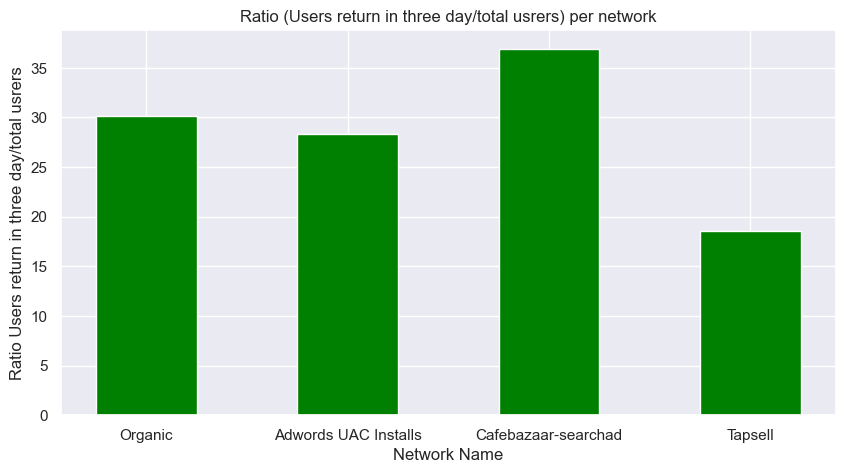

In [19]:
user_return_in_three_day_pd=user_return_in_three_day_df.toPandas()
utils.plot_bar_plot(
    df=user_return_in_three_day_pd,
    x_col='network_name',
    height_col='percentage_users_return_in_three_days_total',
    x_label='Network Name',
    y_label='Ratio Users return in three day/total usrers',
    title='Ratio (Users return in three day/total usrers) per network')

### Retention Rate

In [20]:
window = Window.partitionBy('adid').orderBy(F.col('created_at').cast('long'))
retention_rate_network_df = (
    adjusted_sampled_clean_df
    .filter(F.col('created_at').between(F.col('installed_at'),F.date_add(F.col('installed_at') , 3 )))
    .withColumn('last_activity', F.lag('activity_kind').over(window))
    .filter(F.col('activity_kind') == 'event')
    .withColumn('event_times', F.collect_list(F.col('created_at').cast('long')).over(window.rangeBetween(0,30)))
    .filter(F.col('last_activity') =='install')
    .withColumn('event_count' , F.size('event_times'))
    .groupby('adid', 'network_name').agg(F.round(F.avg(F.col('event_count')/30),2).alias('retention_rate_per_user'))
    .groupby('network_name').agg(F.round(F.avg('retention_rate_per_user'),4).alias('retention_rate'))
)
retention_rate_network_df.show()

+--------------------+--------------+
|        network_name|retention_rate|
+--------------------+--------------+
|             Organic|         0.034|
|Adwords UAC Installs|        0.0335|
| Cafebazaar-searchad|        0.0344|
|             Tapsell|        0.0345|
+--------------------+--------------+



#### barplot

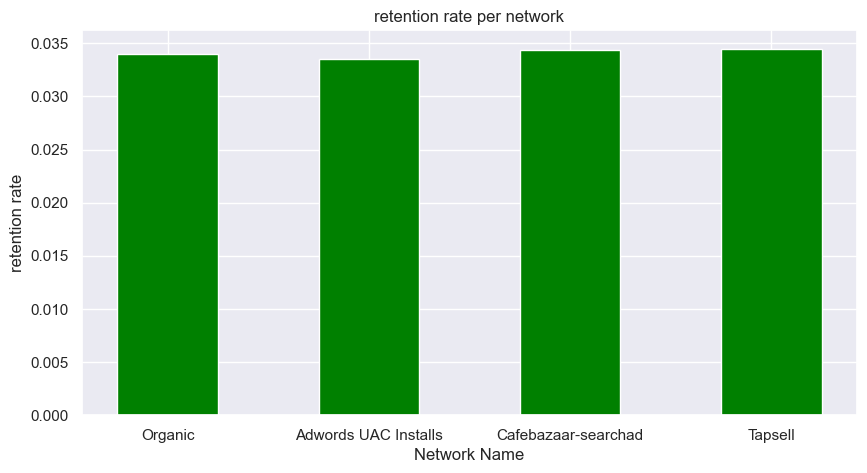

In [21]:
retention_rate_network_pd=retention_rate_network_df.toPandas()
utils.plot_bar_plot(
    df=retention_rate_network_pd,
    x_col='network_name',
    height_col='retention_rate',
    x_label='Network Name',
    y_label='retention rate',
    title='retention rate per network')

## Part2

### Time distribution of installations throughout the day and night

In [22]:
def distribution_installed_per_hour(network_name,event_name):
    installed_distribution_day_df = (
        adjusted_sampled_clean_df
        .filter(F.col('network_name') == network_name )
        .filter(F.col('event_name')==event_name)
        .groupby(F.hour('installed_at').alias('install_hour'))
        .agg(F.count('*').alias('install_count'))
        .orderBy(F.hour('installed_at'))
    )
    installed_distribution_day_pd=installed_distribution_day_df.toPandas()
    sns.scatterplot(data=installed_distribution_day_pd,
                    x='install_hour',
                    y='install_count');

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



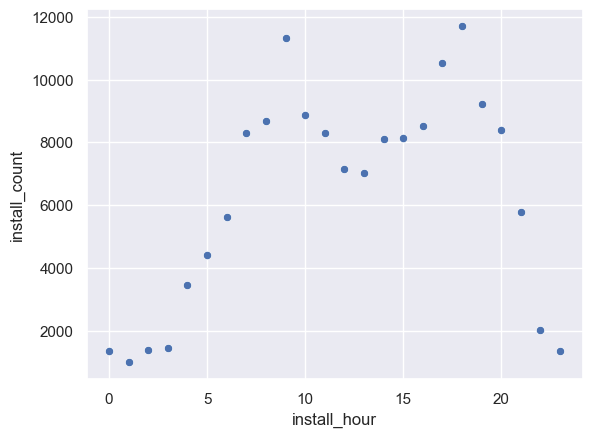

In [23]:
distribution_installed_per_hour(network_name='Organic',event_name='get_contact')

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



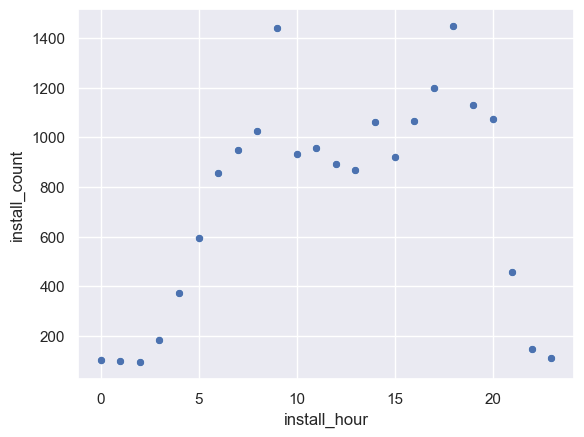

In [24]:
distribution_installed_per_hour(network_name='Organic',event_name='new_post_submit')

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



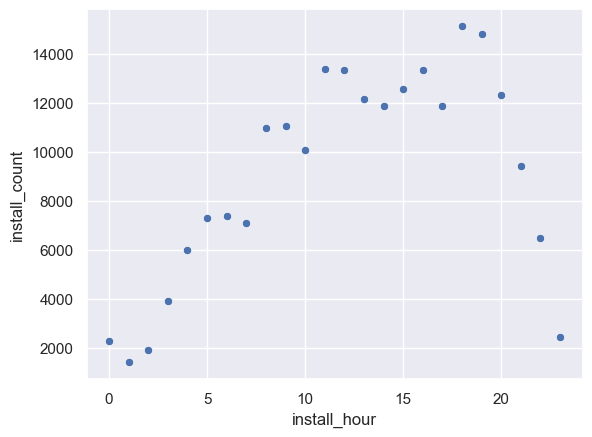

In [25]:
distribution_installed_per_hour(network_name='Adwords UAC Installs',event_name='get_contact')

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



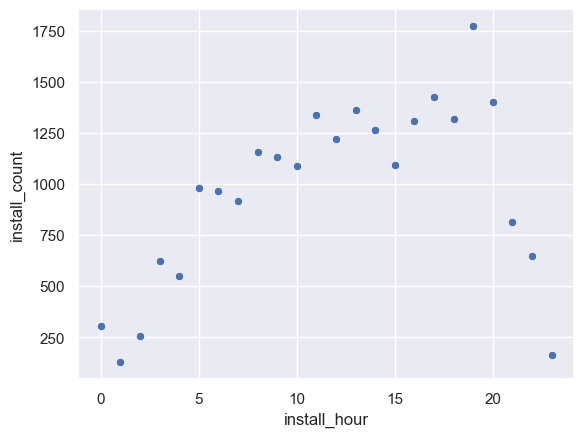

In [26]:
distribution_installed_per_hour(network_name='Adwords UAC Installs',event_name='new_post_submit')

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



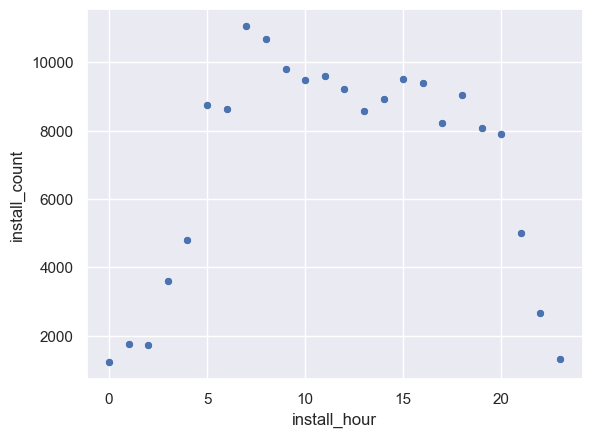

In [27]:
distribution_installed_per_hour(network_name='Cafebazaar-searchad',event_name='get_contact')

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



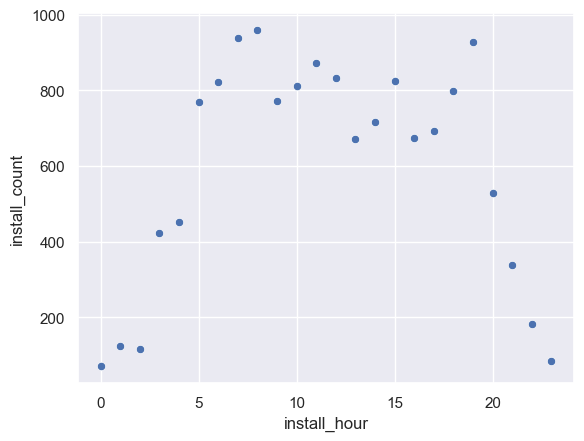

In [28]:
distribution_installed_per_hour(network_name='Cafebazaar-searchad',event_name='new_post_submit')

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



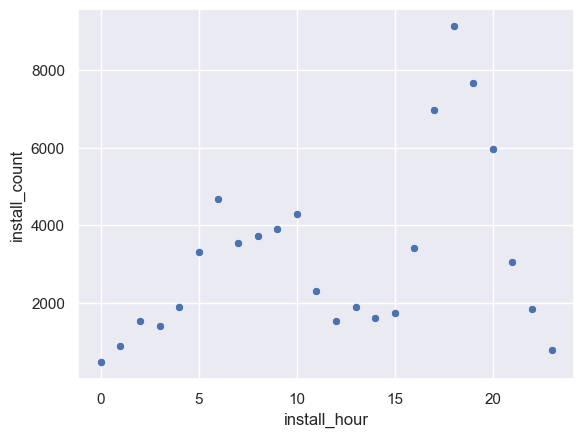

In [29]:
distribution_installed_per_hour(network_name='Tapsell',event_name='get_contact')

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead



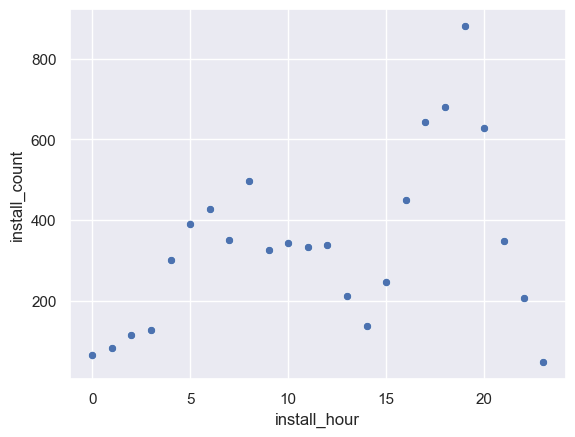

In [30]:
distribution_installed_per_hour(network_name='Tapsell',event_name='new_post_submit')

### The distance between users' events in the app

In [31]:
 def diff_events_users_hist(bins,network_name,event_name):
    window = Window.partitionBy('adid').orderBy(F.col('created_at').cast('long'))
    bins = bins
    diff_events_users_df = (
        adjusted_sampled_clean_df
        .filter(F.col('network_name')==network_name)
        .withColumn('created_at' , F.col('created_at').cast('long'))
        .withColumn('last_created_at', F.lag('created_at').over(window))
        .filter(F.col('event_name') == event_name)
         .withColumn('diff_time_min',(F.col('created_at')-F.col('last_created_at'))/60)
        .groupby('adid').agg(F.round(F.avg('diff_time_min'),0).alias('avg_diff_time_user'))
        .withColumn('avg_diff_time_bins' , bins*F.floor(F.col('avg_diff_time_user')/bins))
        .groupby('avg_diff_time_bins').agg(F.count('*').alias('Users'))
    )
    diff_events_users_pd = diff_events_users_df.toPandas()
    sns.histplot(data = diff_events_users_pd,
        x= 'avg_diff_time_bins',bins=50,kde=True
        );

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



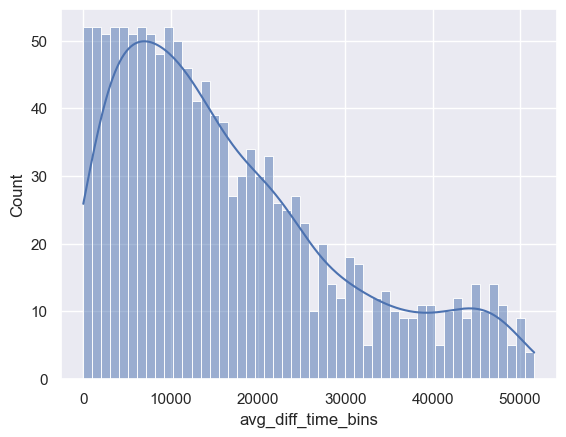

In [32]:
diff_events_users_hist(
    bins=20,
    network_name='Organic',
    event_name='get_contact')

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



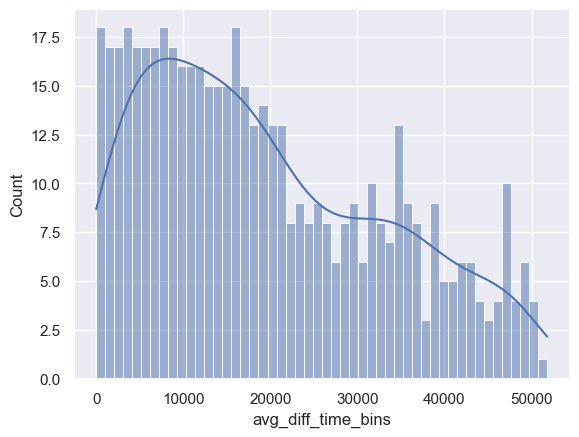

In [33]:
diff_events_users_hist(
    bins=60,
    network_name='Organic',
    event_name='new_post_submit')

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



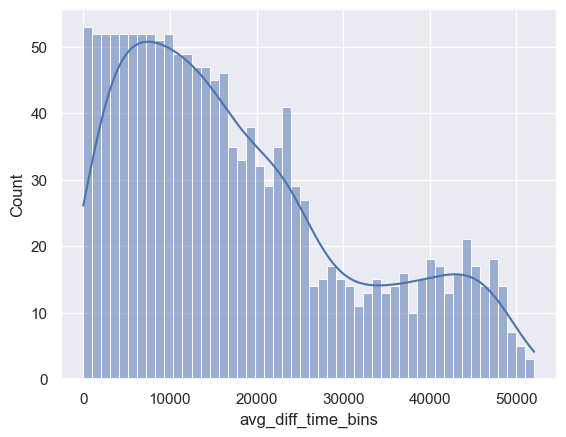

In [34]:
diff_events_users_hist(
    bins=20,
    network_name='Adwords UAC Installs',
    event_name='get_contact')

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



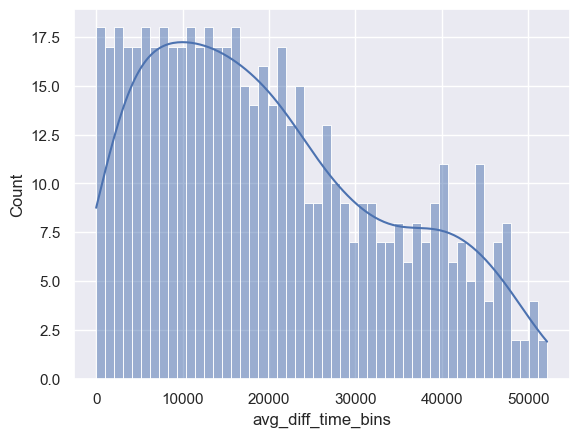

In [35]:
diff_events_users_hist(
    bins=60,
    network_name='Adwords UAC Installs',
    event_name='new_post_submit')

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



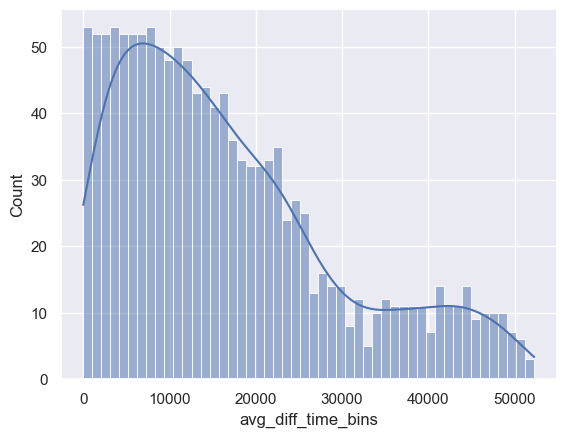

In [36]:
diff_events_users_hist(
    bins=20,
    network_name='Cafebazaar-searchad',
    event_name='get_contact')

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



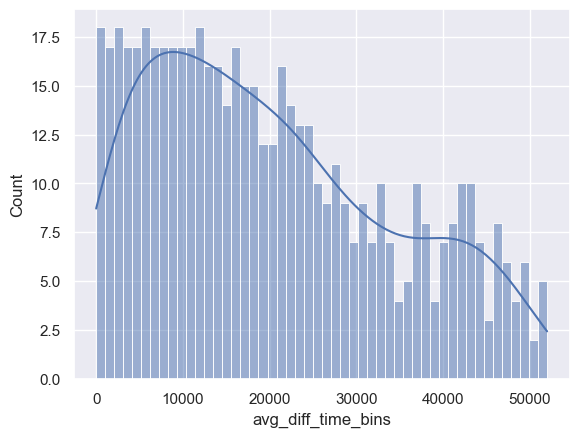

In [37]:
diff_events_users_hist(
    bins=60,
    network_name='Cafebazaar-searchad',
    event_name='new_post_submit')

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



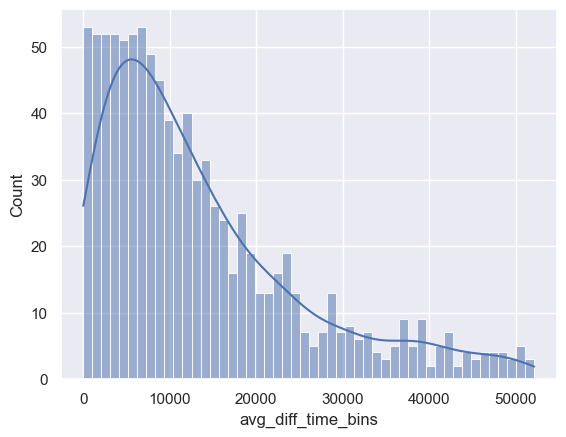

In [38]:
diff_events_users_hist(
    bins=20,
    network_name='Tapsell',
    event_name='get_contact')

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\Lenovo\PycharmProjects\ECommerce\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



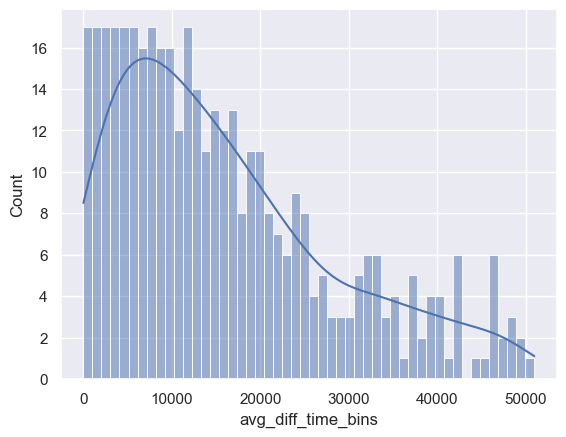

In [39]:
diff_events_users_hist(
    bins=60,
    network_name='Tapsell',
    event_name='new_post_submit')

## Part 3

In [40]:
value_network_df=(
    adjusted_sampled_clean_df
    .withColumn('get_contact' ,F.when(F.col('event_name') == 'get_contact' , 1).otherwise(0))
    .withColumn('new_post_submit' ,F.when(F.col('event_name') == 'new_post_submit' , 1).otherwise(0))
    .withColumn('install' , F.when(F.col('activity_kind') == 'install' , 1).otherwise(0))
    .groupby('network_name')
    .agg(F.sum('get_contact').alias('count_get_contact'),
         F.sum('new_post_submit').alias('count_new_post_submit'),
         F.sum('install').alias('install_count'),
        (F.round(
            (F.sum('get_contact')*10+F.sum('new_post_submit')*100)/(F.sum('install')),2)).alias('value_network'))
)
value_network_df.show()

+--------------------+-----------------+---------------------+-------------+-------------+
|        network_name|count_get_contact|count_new_post_submit|install_count|value_network|
+--------------------+-----------------+---------------------+-------------+-------------+
|             Organic|           152098|                17974|        22783|       145.65|
| Cafebazaar-searchad|           168956|                14401|        23590|       132.67|
|             Tapsell|            77525|                 8172|        18917|        84.18|
|Adwords UAC Installs|           218762|                23257|        24092|       187.34|
+--------------------+-----------------+---------------------+-------------+-------------+

